In [1]:
import numpy as np
import operator
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division

In [2]:
from sklearn import datasets
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split, ShuffleSplit
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import scale
import datetime as dt
from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.learning_curve import learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
# load data
votes_df = pd.read_csv('cleaned_votes_money_history.csv')
votes_df['date'] = pd.to_datetime(votes_df['date'])
votes_df = votes_df.fillna(0)
votes_df = votes_df.drop('Unnamed: 0', 1)

In [4]:
# What columns is in this dataframe?
votes_df.columns

Index([u'ABORTION POLICY PRO-CHOICE', u'ACCOUNTANTS', u'BUSINESS SERVICES',
       u'DEFENSE AEROSPACE', u'DEFENSE ELECTRONICS', u'DEMOCRATIC LIBERAL',
       u'ENVIRONMENT', u'FOREIGN & DEFENSE POLICY', u'GENERAL CONTRACTORS',
       u'LOBBYISTS', u'MISC DEFENSE', u'PUBLIC SECTOR UNIONS',
       u'WOMEN'S ISSUES', u'bill_id', u'class_variable', u'date',
       u'display_name', u'first_name', u'id', u'last_name', u'no',
       u'not voting', u'opensecrets_id', u'party', u'prior_no_total',
       u'prior_total', u'prior_vote_score', u'prior_yea_percent',
       u'prior_yea_total', u'state', u'subjects_top_terms', u'yea',
       u'total_votes_on_bill'],
      dtype='object')

In [5]:
# glimpse at the data
votes_df.tail()

,ABORTION POLICY PRO-CHOICE,ACCOUNTANTS,BUSINESS SERVICES,DEFENSE AEROSPACE,DEFENSE ELECTRONICS,DEMOCRATIC LIBERAL,ENVIRONMENT,FOREIGN & DEFENSE POLICY,GENERAL CONTRACTORS,LOBBYISTS,...,party,prior_no_total,prior_total,prior_vote_score,prior_yea_percent,prior_yea_total,state,subjects_top_terms,yea,total_votes_on_bill
51116,0,0,0,0,0,0,0,0,0,0,...,D,0,0,0,0.000000,0,OR,Armed forces and national security,1,410
51117,18912,0,5200,0,1500,7500,8508,1864,0,3000,...,D,0,1,1,1.000000,1,OR,Armed forces and national security,1,418
51118,18912,0,5200,2000,1500,7500,9008,1876,0,3750,...,D,0,2,2,1.000000,2,OR,Armed forces and national security,0,418
51119,21412,0,5700,7000,1500,8500,9008,2034,2000,8500,...,D,1,3,1,0.666667,2,OR,Armed forces and national security,1,418
51120,21412,0,5700,7000,1500,8500,9008,2301,2000,8750,...,D,1,4,2,0.750000,3,OR,Armed forces and national security,0,412


In [6]:
# Dataframe for one congressperson
votes_df[votes_df['opensecrets_id'] == 'N00000010']

,ABORTION POLICY PRO-CHOICE,ACCOUNTANTS,BUSINESS SERVICES,DEFENSE AEROSPACE,DEFENSE ELECTRONICS,DEMOCRATIC LIBERAL,ENVIRONMENT,FOREIGN & DEFENSE POLICY,GENERAL CONTRACTORS,LOBBYISTS,...,party,prior_no_total,prior_total,prior_vote_score,prior_yea_percent,prior_yea_total,state,subjects_top_terms,yea,total_votes_on_bill
0,0,0,0,250,0,0,0,0,500,0,...,R,0,0,0,0.000000,0,IN,Armed forces and national security,1,208
1,0,0,0,250,0,0,0,0,500,0,...,R,0,1,1,1.000000,1,IN,Armed forces and national security,1,208
2,0,0,1000,550,0,0,0,500,500,250,...,R,0,2,2,1.000000,2,IN,Armed forces and national security,1,208
3,0,0,1000,1150,0,0,0,500,800,250,...,R,0,3,3,1.000000,3,IN,Armed forces and national security,1,208
4,0,0,1000,1150,0,0,0,500,800,250,...,R,0,4,4,1.000000,4,IN,Armed forces and national security,1,208
5,0,0,4750,2650,0,0,0,10050,6100,5300,...,R,0,5,5,1.000000,5,IN,Armed forces and national security,0,208
6,0,0,4750,2650,0,0,0,10050,6100,5300,...,R,1,6,4,0.833333,5,IN,Armed forces and national security,0,208
7,0,0,4750,2650,0,0,0,10050,6100,5300,...,R,2,7,3,0.714286,5,IN,Armed forces and national security,0,208
8,0,0,4750,2650,0,0,0,10050,6100,5300,...,R,3,8,2,0.625000,5,IN,Armed forces and national security,0,208
9,0,0,4750,2650,0,0,0,10050,6100,5300,...,R,4,9,1,0.555556,5,IN,Armed forces and national security,1,208


**How many times does an indepent show up in this data set?**

In [7]:
votes_df[votes_df['party'] == 'I'].shape[0]

15

**Later I will use political party as a predictor variable. Since there are only 15 time an independent votes in this data set, I will remove that party. That way when creating dummies it can be a binary feature.**

In [8]:
votes_df = votes_df[votes_df['party'] != 'I']

In [9]:
votes_df.shape[0]

51106

In [10]:
# refresher of the features available
votes_df.columns

Index([u'ABORTION POLICY PRO-CHOICE', u'ACCOUNTANTS', u'BUSINESS SERVICES',
       u'DEFENSE AEROSPACE', u'DEFENSE ELECTRONICS', u'DEMOCRATIC LIBERAL',
       u'ENVIRONMENT', u'FOREIGN & DEFENSE POLICY', u'GENERAL CONTRACTORS',
       u'LOBBYISTS', u'MISC DEFENSE', u'PUBLIC SECTOR UNIONS',
       u'WOMEN'S ISSUES', u'bill_id', u'class_variable', u'date',
       u'display_name', u'first_name', u'id', u'last_name', u'no',
       u'not voting', u'opensecrets_id', u'party', u'prior_no_total',
       u'prior_total', u'prior_vote_score', u'prior_yea_percent',
       u'prior_yea_total', u'state', u'subjects_top_terms', u'yea',
       u'total_votes_on_bill'],
      dtype='object')

Modeling
==

## Test with campaign contributions as predictor varaibles:

## PCA with SVM 

## Model #1
Contributions as X features

**Find parameters to use for SVM**
Since grid search with SVM is computationally heave, I will get the parameters to use by subsetting the votes_df to 500 data points.

In [38]:
# Because of the computation expense of SVM I will subset the dataframe from
# 51,106 data points to 500
votes_df_modeling = votes_df.sample(500, random_state=2)

# For X, remove  all features that are not industries that can contribut to a campain
# y will be the class variable/how the congress person voted
# 1 = yea, 0 = present, but did not participate in vote, -1 = no
X, y = votes_df_modeling.drop([u'bill_id', u'class_variable', u'date',u'display_name', 
                                     u'first_name', u'id', u'last_name', u'no',u'not voting',
                                     u'opensecrets_id', u'prior_no_total', u'prior_total',
                                     u'prior_vote_score', u'prior_yea_percent', u'prior_yea_total',
                                     u'state', u'subjects_top_terms', u'yea', 'party', 'total_votes_on_bill'],
                                    1), votes_df_modeling['class_variable']

# since there are large disparities in contributions I will scall the data
X_scale = scale(X)

# Setup the experiment with test/train and cv
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, 
                                                    test_size=0.2, random_state=2)

cv = ShuffleSplit(X_train.shape[0], n_iter=5, test_size=0.2, random_state=6)

In [16]:
X_scale

array([[  0.00000000e+00,   3.07868334e-02,   6.03421935e-01, ...,
          0.00000000e+00,   0.00000000e+00,   1.53934167e-01],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          2.21433404e-01,   9.68771142e-01,   1.38395877e-02],
       [  7.04744836e-06,   0.00000000e+00,   5.26796765e-01, ...,
          2.32389610e-01,   3.79966702e-01,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   9.80899014e-02, ...,
          6.13609749e-02,   4.99653653e-02,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   4.11154999e-01, ...,
          7.47554544e-02,   5.98043635e-01,   0.00000000e+00],
       [  4.33016781e-03,   0.00000000e+00,   2.19498698e-01, ...,
          3.79205688e-02,   7.20541368e-01,   0.00000000e+00]])

In [39]:
# We will look at X instead of X_scale
# because when we scale the data we lose the feature names 
# in the dataframe
X.head(2)

,ABORTION POLICY PRO-CHOICE,ACCOUNTANTS,BUSINESS SERVICES,DEFENSE AEROSPACE,DEFENSE ELECTRONICS,DEMOCRATIC LIBERAL,ENVIRONMENT,FOREIGN & DEFENSE POLICY,GENERAL CONTRACTORS,LOBBYISTS,MISC DEFENSE,PUBLIC SECTOR UNIONS,WOMEN'S ISSUES
50315,0,500,9800,0,0,0,0,1000,2201,12465,0,0,2500
47103,0,0,0,0,0,0,0,0,0,2000,4000,17500,250


In [44]:
# time how long this takes to perform
# varible for starting the block of code
start = dt.datetime.now()

# variable for parameters to try
params = {'C': np.linspace(.001, 10, 10), 'kernel': ['poly', 'rbf', 'linear'],
         'degree': range(1,4), 'gamma': np.linspace(.001, 10, 10)}
clf = SVC()
grid = GridSearchCV(clf, params, cv=cv, n_jobs=-1)

# fir the data with multiple parameters
grid.fit(X_train, y_train)
print '{} seconds'.format((dt.datetime.now() - start).seconds)

1385 seconds


In [45]:
grid.best_params_

{'C': 0.001, 'degree': 2, 'gamma': 1.1119999999999999, 'kernel': 'poly'}

**Take best parameters and use in PCA-SVM model**

**Re-subset data, and set up test-train**

In [17]:
# Because of the computation expense of SVM I will subset the dataframe from
# 51,106 data points to 10,000
votes_df_modeling = votes_df.sample(10000, random_state=2)

# For X, remove  all features that are not industries that can contribut to a campain
# y will be the class variable/how the congress person voted
# 1 = yea, 0 = present, but did not participate in vote, -1 = no
X, y = votes_df_modeling.drop([u'bill_id', u'class_variable', u'date',u'display_name', 
                                     u'first_name', u'id', u'last_name', u'no',u'not voting',
                                     u'opensecrets_id', u'prior_no_total', u'prior_total',
                                     u'prior_vote_score', u'prior_yea_percent', u'prior_yea_total',
                                     u'state', u'subjects_top_terms', u'yea', 'party', 'total_votes_on_bill'],
                                    1), votes_df_modeling['class_variable']

# since there are large disparities in contributions I will scall the data
X_scale = scale(X)

# Setup the experiment with test/train and cv
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, 
                                                    test_size=0.2, random_state=2)

cv = ShuffleSplit(X_train.shape[0], n_iter=5, test_size=0.2, random_state=6)

In [18]:
# We will look at X instead of X_scale
# because when we scale the data we lose the feature names 
# in the dataframe
X.head(2)

,ABORTION POLICY PRO-CHOICE,ACCOUNTANTS,BUSINESS SERVICES,DEFENSE AEROSPACE,DEFENSE ELECTRONICS,DEMOCRATIC LIBERAL,ENVIRONMENT,FOREIGN & DEFENSE POLICY,GENERAL CONTRACTORS,LOBBYISTS,MISC DEFENSE,PUBLIC SECTOR UNIONS,WOMEN'S ISSUES
50315,0,500,9800,0,0,0,0,1000,2201,12465,0,0,2500
47103,0,0,0,0,0,0,0,0,0,2000,4000,17500,250


In [19]:
n_components_input = X.columns.shape[0]
pca = PCA(n_components=n_components_input)
pca.fit(X_train)

tot = sum(pca.explained_variance_ratio_)
var_exp = [(i / tot)*100 for i in sorted(pca.explained_variance_ratio_, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print var_exp
print cum_var_exp

[44.625292101793256, 13.885158636561984, 11.047967508930965, 9.3394765568854581, 5.4157570840459872, 4.6923227771425688, 3.0541823146654452, 2.541577576214332, 1.8005249615715047, 1.5610363044559759, 1.2005575713547931, 0.80212315819267677, 0.03402344818508856]
[  44.6252921    58.51045074   69.55841825   78.8978948    84.31365189
   89.00597467   92.06015698   94.60173456   96.40225952   97.96329582
   99.16385339   99.96597655  100.        ]


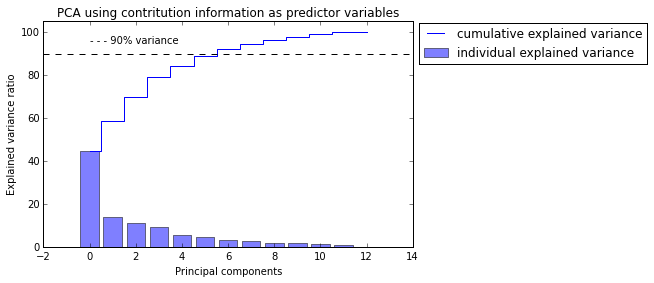

In [20]:
# plot variance
# add dotted line at 90%
plt.figure(figsize=(6, 4))

plt.bar(range(n_components_input), var_exp, alpha=0.5, align='center', 
        label='individual explained variance')
plt.step(range(n_components_input), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.ylim(0, 105)
plt.legend(bbox_to_anchor=(1.65, 1.02))
plt.axhline(y=90, ls='dashed', lw=1, color='black')
plt.annotate('- - - 90% variance', xy=(0, 95), xytext=(0, 95))
plt.title("PCA using contritution information as predictor variables")
plt.tight_layout()

In [22]:
## Run models
# first run PCA for dimension reduction
# then run SVM with reduced dimensions

start = dt.datetime.now()
# run pca

pca = PCA(n_components=.9, whiten=True)
pca.fit(X_train)
X_t_train = pca.transform(X_train)
X_t_test = pca.transform(X_test)

# Run SVM

clf = SVC(C=0.001, degree=3, gamma=1.1119999999999999, kernel='poly')
clf.fit(X_t_train, y_train)
print 'pred label', clf.predict(X_t_test)
print "\nBelow are the results of using contritution information as predictor variables:"
print classification_report(clf.predict(X_t_test), y_test)
print '{} seconds'.format((dt.datetime.now() - start).seconds)

pred label [1 1 1 ..., 1 1 1]

Below are the results of using contritution information as predictor variables:
             precision    recall  f1-score   support

         -1       0.00      0.00      0.00         0
          0       0.00      0.00      0.00         0
          1       1.00      0.70      0.83      2000

avg / total       1.00      0.70      0.83      2000

1 seconds


In [23]:
print 'yea baseline (test data): {}%%'.format(sum(pd.DataFrame(y_test)['class_variable']==1)/pd.DataFrame(y_test).shape[0]*100)
print 'no baseline (test data): {}%%'.format(sum(pd.DataFrame(y_test)['class_variable']==-1)/pd.DataFrame(y_test).shape[0]*100)
print 'not vote baseline (test data): {}%%'.format(sum(pd.DataFrame(y_test)['class_variable']==0)/pd.DataFrame(y_test).shape[0]*100)

print '\nyea baseline (all data): {}%%'.format(sum(votes_df['class_variable']==1)/votes_df.shape[0]*100)
print 'no baseline (all data): {}%%'.format(sum(votes_df['class_variable']==-1)/votes_df.shape[0]*100)
print 'not vote baseline (all data): {}%%'.format(sum(votes_df['class_variable']==0)/votes_df.shape[0]*100)

yea baseline (test data): 70.3%%
no baseline (test data): 26.5%%
not vote baseline (test data): 3.2%%

yea baseline (all data): 70.8194732517%%
no baseline (all data): 26.4469925253%%
not vote baseline (all data): 2.73353422299%%


## Model #2
Historical voting patterns as X features

In [11]:
# Because of the computation expense of SVM I will subset the dataframe from
# 51,106 data points to 10,000
votes_df_modeling = votes_df.sample(100, random_state=2)

# For X, remove  all features that are not industries that can contribut to a campain
# y will be the class variable/how the congress person voted
# 1 = yea, 0 = present, but did not participate in vote, -1 = no
X, y = votes_df_modeling.drop([u'ABORTION POLICY PRO-CHOICE', u'ACCOUNTANTS', u'BUSINESS SERVICES',
                               u'DEFENSE AEROSPACE', u'DEFENSE ELECTRONICS', u'DEMOCRATIC LIBERAL',
                               u'ENVIRONMENT', u'FOREIGN & DEFENSE POLICY', u'GENERAL CONTRACTORS',
                               u'LOBBYISTS', u'MISC DEFENSE', u'PUBLIC SECTOR UNIONS',
                               u"WOMEN'S ISSUES", u'bill_id', u'class_variable', u'date',
                               u'display_name', u'first_name', u'id', u'last_name', u'no',
                               u'not voting', u'opensecrets_id', u'state', u'subjects_top_terms', u'yea',
                               'total_votes_on_bill'],1), votes_df_modeling['class_variable']
X = pd.get_dummies(X).drop(['party_R'], 1)

# Scale data
X_scale = scale(X)

# Setup the experiment with test/train and cv
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, 
                                                    test_size=0.2, random_state=2)

cv = ShuffleSplit(X_train.shape[0], n_iter=5, test_size=0.2, random_state=6)



In [12]:
# We will look at X instead of X_scale
# because when we scale the data we lose the feature names 
# in the dataframe
X.head(2)

,prior_no_total,prior_total,prior_vote_score,prior_yea_percent,prior_yea_total,party_D
50315,1,6,4,0.833333,5,0
47103,0,3,3,1.000000,3,1


In [13]:
# time how long this takes to perform
# varible for starting the block of code
start = dt.datetime.now()

# variable for parameters to try
params = {'C': np.linspace(.001, 10, 10), 'kernel': ['poly', 'rbf', 'linear'],
         'degree': range(1,4), 'gamma': np.linspace(.001, 10, 10)}
clf = SVC()
grid = GridSearchCV(clf, params, cv=cv, n_jobs=-1)

# fir the data with multiple parameters
grid.fit(X_train, y_train)
print '{} seconds'.format((dt.datetime.now() - start).seconds)

263 seconds


In [14]:
grid.best_params_

{'C': 1.1119999999999999,
 'degree': 3,
 'gamma': 3.3340000000000001,
 'kernel': 'poly'}

**Take best parameters and use in PCA-SVM model**

**Re-subset data, and set up test-train**

In [24]:
# Because of the computation expense of SVM I will subset the dataframe from
# 51,106 data points to 10,000
votes_df_modeling = votes_df.sample(10000, random_state=2)

# For X, remove  all features that are not industries that can contribut to a campain
# y will be the class variable/how the congress person voted
# 1 = yea, 0 = present, but did not participate in vote, -1 = no
X, y = votes_df_modeling.drop([u'ABORTION POLICY PRO-CHOICE', u'ACCOUNTANTS', u'BUSINESS SERVICES',
                               u'DEFENSE AEROSPACE', u'DEFENSE ELECTRONICS', u'DEMOCRATIC LIBERAL',
                               u'ENVIRONMENT', u'FOREIGN & DEFENSE POLICY', u'GENERAL CONTRACTORS',
                               u'LOBBYISTS', u'MISC DEFENSE', u'PUBLIC SECTOR UNIONS',
                               u"WOMEN'S ISSUES", u'bill_id', u'class_variable', u'date',
                               u'display_name', u'first_name', u'id', u'last_name', u'no',
                               u'not voting', u'opensecrets_id', u'state', u'subjects_top_terms', u'yea',
                               'total_votes_on_bill'],1), votes_df_modeling['class_variable']
X = pd.get_dummies(X).drop(['party_R'], 1)

# Scale data
X_scale = scale(X)

# Setup the experiment with test/train and cv
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, 
                                                    test_size=0.2, random_state=2)

cv = ShuffleSplit(X_train.shape[0], n_iter=5, test_size=0.2, random_state=6)

In [25]:
# We will look at X instead of X_scale
# because when we scale the data we lose the feature names 
# in the dataframe
X.head(2)

,prior_no_total,prior_total,prior_vote_score,prior_yea_percent,prior_yea_total,party_D
50315,1,6,4,0.833333,5,0
47103,0,3,3,1.000000,3,1


In [26]:
n_components_input = X.columns.shape[0]
pca = PCA(n_components=n_components_input)
pca.fit(X_train)

tot = sum(pca.explained_variance_ratio_)
var_exp = [(i / tot)*100 for i in sorted(pca.explained_variance_ratio_, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print var_exp
print cum_var_exp

[74.781129816818265, 18.333067856217873, 3.6681307237102438, 2.9587344393502395, 0.25893716390338595, 1.7347547674101278e-28]
[  74.78112982   93.11419767   96.7823284    99.74106284  100.          100.        ]


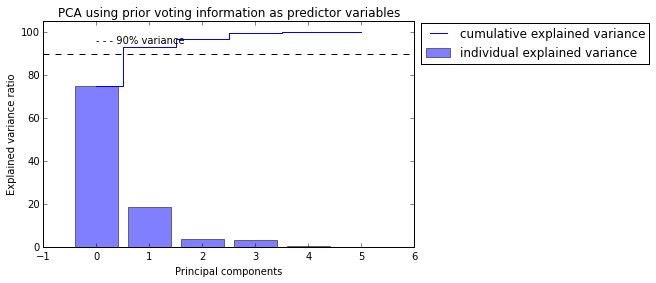

In [27]:
# plot variance
# add dotted line at 90%
plt.figure(figsize=(6, 4))

plt.bar(range(n_components_input), var_exp, alpha=0.5, align='center', 
        label='individual explained variance')
plt.step(range(n_components_input), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.ylim(0, 105)
plt.legend(bbox_to_anchor=(1.65, 1.02))
plt.axhline(y=90, ls='dashed', lw=1, color='black')
plt.annotate('- - - 90% variance', xy=(0, 95), xytext=(0, 95))
plt.title("PCA using prior voting information as predictor variables")
plt.tight_layout()

In [28]:
## Run models
# first run PCA for dimension reduction
# then run SVM with reduced dimensions

start = dt.datetime.now()
# run pca
print "PCA starting"

pca = PCA(n_components=.9, whiten=True)
pca.fit(X_train)
X_t_train = pca.transform(X_train)
X_t_test = pca.transform(X_test)

# Run SVM
print "SVM starting"

clf = SVC(C=0.001, degree=3, gamma=3.3340000000000001, kernel='poly')
clf.fit(X_t_train, y_train)
print 'pred label', clf.predict(X_t_test)
print "\nBelow are the results of using prior voting information as predictor variables:"
print classification_report(clf.predict(X_t_test), y_test)
print '{} seconds'.format((dt.datetime.now() - start).seconds)

PCA starting
SVM starting
pred label [ 1  1  1 ...,  1 -1  1]

Below are the results of using prior voting information as predictor variables:
             precision    recall  f1-score   support

         -1       0.02      0.52      0.04        23
          0       0.00      0.00      0.00         0
          1       0.99      0.71      0.83      1977

avg / total       0.98      0.70      0.82      2000

12 seconds


In [22]:
print 'yea baseline (test data): {}%%'.format(sum(pd.DataFrame(y_test)['class_variable']==1)/pd.DataFrame(y_test).shape[0]*100)
print 'no baseline (test data): {}%%'.format(sum(pd.DataFrame(y_test)['class_variable']==-1)/pd.DataFrame(y_test).shape[0]*100)
print 'not vote baseline (test data): {}%%'.format(sum(pd.DataFrame(y_test)['class_variable']==0)/pd.DataFrame(y_test).shape[0]*100)

print '\nyea baseline (all data): {}%%'.format(sum(votes_df['class_variable']==1)/votes_df.shape[0]*100)
print 'no baseline (all data): {}%%'.format(sum(votes_df['class_variable']==-1)/votes_df.shape[0]*100)
print 'not vote baseline (all data): {}%%'.format(sum(votes_df['class_variable']==0)/votes_df.shape[0]*100)

yea baseline (test data): 70.3%%
no baseline (test data): 26.5%%
not vote baseline (test data): 3.2%%

yea baseline (all data): 70.8194732517%%
no baseline (all data): 26.4469925253%%
not vote baseline (all data): 2.73353422299%%


Get Feature Importance:
==

Log Reg
==
Get coeffients and see how biased the data is

In [23]:
# Because of the computation expense of SVM I will subset the dataframe from
# 51,106 data points to 10,000
votes_df_modeling = votes_df.sample(10000, random_state=2)

# For X, remove  all features that are not industries that can contribut to a campain
# y will be the class variable/how the congress person voted
# 1 = yea, 0 = present, but did not participate in vote, -1 = no
X, y = votes_df_modeling.drop([u'bill_id', u'class_variable', u'date',u'display_name', 
                                     u'first_name', u'id', u'last_name', u'no',u'not voting',
                                     u'opensecrets_id', u'prior_no_total', u'prior_total',
                                     u'prior_vote_score', u'prior_yea_percent', u'prior_yea_total',
                                     u'state', u'subjects_top_terms', u'yea', 'party', 'total_votes_on_bill'],
                                    1), votes_df_modeling['class_variable']

# since there are large disparities in contributions I will scall the data
X_scale = scale(X)

# Setup the experiment with test/train and cv
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, 
                                                    test_size=0.2, random_state=2)

cv = ShuffleSplit(X_train.shape[0], n_iter=5, test_size=0.2, random_state=6)

In [24]:
feature_cols =  X.columns

In [25]:
stdsc = StandardScaler()

In [26]:
# transform our training features
X_train_std = stdsc.fit_transform(X_train)
# transform the testing features in the same way
X_test_std = stdsc.transform(X_test)

penalty: 'l1' for lasso, 'l2' for ridge

In [27]:
logreg = LogisticRegression(penalty='l1', C=10)

In [28]:
start = dt.datetime.now()
import numpy as np
from sklearn.grid_search import GridSearchCV
# gridsearch for hyperparameters
# the parameters we want to search in a dictionary
# use the parameter name from sklearn as the key
# and the possible values you want to test as the values
parameters = {'C': np.linspace(1e-5, 1e5, 100), 'class_weight': [None, 'auto']}
logreg2 = LogisticRegression()           
clf = GridSearchCV(logreg2, parameters, cv=cv)
clf.fit(X_train_std, y_train)
print '{} seconds'.format((dt.datetime.now() - start).seconds)

72 seconds


In [29]:
best_log = clf.best_estimator_

In [30]:
clf.best_score_

0.70787500000000003

In [31]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                       train_sizes=np.linspace(.2,1.0,10), n_jobs=1):
    """Create a learning curve to help
    us determine if we are overfitting
    or underfitting.
    
    Parameters
    ----------
    estimator (variable name) : our ML algorithm we want to plot

    title (string) : title for our chart

    X : our training dataframe

    y : our training labels

    ylim (tuple): min, max of the score, ie % accuracy

    cv (variable name) : pass through for our CV strategy
    
    train_sizes (list-like) : the increments of % of our training data to use
    """
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    
    plt.xlabel("Number of training examples used")
    plt.ylabel("Accuracy")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


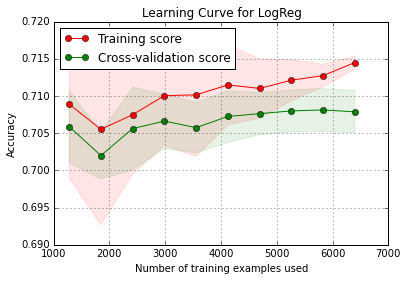

In [32]:
%matplotlib inline
plot_learning_curve(best_log, 'Learning Curve for LogReg', X_train_std, y_train, cv=cv);

In [33]:
pd.DataFrame({'features': X.columns, 'coefficients': best_log.coef_[0]}).sort_values(by='coefficients', ascending=False)

,coefficients,features
2,0.000837,BUSINESS SERVICES
1,0.000478,ACCOUNTANTS
0,0.000458,ABORTION POLICY PRO-CHOICE
12,0.000316,WOMEN'S ISSUES
9,0.000256,LOBBYISTS
11,0.000247,PUBLIC SECTOR UNIONS
7,0.000195,FOREIGN & DEFENSE POLICY
8,0.000148,GENERAL CONTRACTORS
6,-0.000119,ENVIRONMENT
10,-0.000214,MISC DEFENSE


Random Forest
==

In [34]:
# Because of the computation expense of SVM I will subset the dataframe from
# 51,106 data points to 10,000
votes_df_modeling = votes_df.sample(10000, random_state=2)

# For X, remove  all features that are not industries that can contribut to a campain
# y will be the class variable/how the congress person voted
# 1 = yea, 0 = present, but did not participate in vote, -1 = no
X, y = votes_df_modeling.drop([u'bill_id', u'class_variable', u'date',u'display_name', 
                                     u'first_name', u'id', u'last_name', u'no',u'not voting',
                                     u'opensecrets_id', u'prior_no_total', u'prior_total',
                                     u'prior_vote_score', u'prior_yea_percent', u'prior_yea_total',
                                     u'state', u'subjects_top_terms', u'yea', 'party', 'total_votes_on_bill'],
                                    1), votes_df_modeling['class_variable']

# since there are large disparities in contributions I will scall the data
X_scale = scale(X)

# Setup the experiment with test/train and cv
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, 
                                                    test_size=0.2, random_state=2)

cv = ShuffleSplit(X_train.shape[0], n_iter=5, test_size=0.2, random_state=6)

In [35]:
start = dt.datetime.now()
model = DecisionTreeClassifier(
                max_depth = 2,
                min_samples_leaf = 5)

model.fit(X, y)
scores = cross_val_score(model, X, y, scoring='accuracy', cv=5)
print('CV accuracy {}, Average accuracy {}'.format(scores, scores.mean()))
print '{} seconds'.format((dt.datetime.now() - start).seconds)

CV accuracy [ 0.71064468  0.71064468  0.711       0.71085543  0.71135568], Average accuracy 0.710900092175
0 seconds


In [36]:
model = RandomForestClassifier(n_estimators = 20)
    
model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [37]:
features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)
features_df = features_df.reset_index(drop=True)

features_df.sort_values(by='Importance Score', ascending=False)

,Features,Importance Score
0,LOBBYISTS,0.144548
1,GENERAL CONTRACTORS,0.124035
2,BUSINESS SERVICES,0.122659
3,PUBLIC SECTOR UNIONS,0.115573
4,DEFENSE AEROSPACE,0.093998
5,DEFENSE ELECTRONICS,0.083013
6,MISC DEFENSE,0.069532
7,FOREIGN & DEFENSE POLICY,0.056246
8,DEMOCRATIC LIBERAL,0.054156
9,ENVIRONMENT,0.053257
